# Проект "Мэтчинг товаров маркетплейса"

В рамках проекта стоит задача определния перечня из 5ти наиболее близких по характеристикам, описанию и иных обезличенных данных (признаках) некоторого (обезличенного/закодированного) товара среди набора товаров, из базы которого получен сам семпл для поиска наиболее схожих позиций.  

Для анализа и обучения модели ранжирования, получены 4 набра данных (datasets):
- base dataset: содержит немногим меньше 3х млн записей с характеристиками товаров. Основной набор данных, содержащий всю имеющуюся базу товаров. Наиболее схожие товары не размечены.
- train dataset: содержит 10000 позиций, и имеет разметку в виде наиболее схожего товара из перечня всей базы товаров (base dataset).
- validation: содержит 10000 позиций, и необходим для финального тестирования, т.к. имеет отдельно предоставленную разметку.
- validation_answer: разметка для набора данных validation.

Впроцессе анализа и разработки решения определены два основных аспекта, усложняющие исследования:
- большой размер базы товаров (около 1.6 Гб в памяти),
- ббольшое количество признаков для каждого товара (72 признака).
Работа с такими данными требует определенных подходов и оптимизированных алгоритмов, которые исследовались и применялись в проекте для достижения приемлемой точности сопоставления товаров.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

import faiss
import time

import optuna

## 1. Исследование и знакомство с данными

На первом этапе загрузим данные и проведем сводный анализ.  
1. Загрузим данные,
2. Посмотрим информацию по наборам, в том числе пропущенные значения и типы данных,
3. Посмотрим сводную статистику
4. Проверим количество дубликатов,
5. Проверим коррелирующие признаки,
6. Визуализируем признаки с помощью графиков - гистограмма и диаграмма размаха

Для некоторых операций на данном этапе и в будущем не будем использовать весь набор данных, воспользуемся случайной выборкой с предположением о достаточности выборки для репрезентативного представления исходного набора данных.

In [2]:
base = pd.read_csv("data/base.csv", index_col="Id")

In [3]:
base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [5]:
train = pd.read_csv("data/train.csv", index_col="Id")

In [6]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [8]:
print("Количество дубликатов в индексах: ", train.index.duplicated().sum())

Количество дубликатов в индексах:  0


In [60]:
correlation_matrix = train.drop("Target", axis=1).corr()
correlation_threshold = 0.5
# Выборка пар признаков с корреляцией выше порога
high_corr = correlation_matrix.abs() > correlation_threshold
print("Количество взаимнокоррелирующих признаков, с коэффициентом корреляции  > 0.5: ", high_corr.sum().sum() - (train.shape[1] - 1))

Количество взаимнокоррелирующих признаков, с коэффициентом корреляции  > 0.5:  0


In [10]:
validation = pd.read_csv("data/validation.csv", index_col="Id")

In [11]:
validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [12]:
validation.shape

(100000, 72)

In [13]:
validation_answer = pd.read_csv("data/validation_answer.csv", index_col="Id")

In [14]:
validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [15]:
display(train.info())
display(train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


-------------------------------------------
Распределение данных BASE dataset
-------------------------------------------


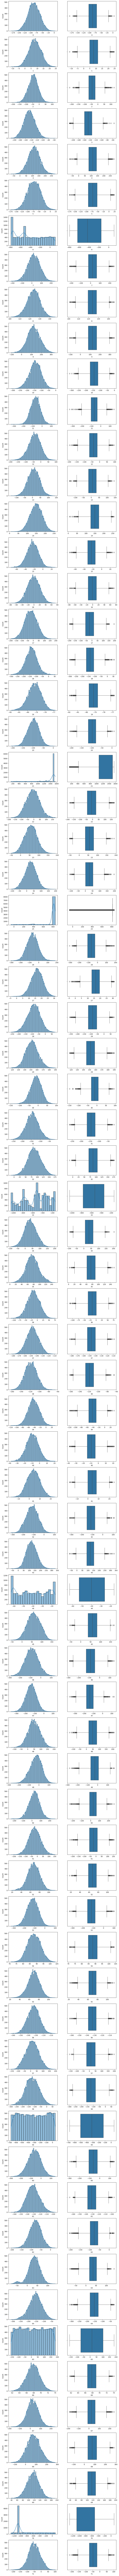

In [57]:
def hist_box_plot(data, text):
    name_cols = data.columns
    num_cols = len(name_cols)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, num_cols * 4))
    print("-------------------------------------------")
    print(f'Распределение данных {text}')
    print("-------------------------------------------")
    for i, name_col in enumerate(name_cols):
        sns.histplot(ax=axes[i,0], data=data, x=name_col, kde=True)
        sns.boxplot(ax=axes[i,1], data=data, x=name_col)
    plt.show()

sample_size = 10000
sample = base.sample(n=sample_size, random_state=0)
hist_box_plot(sample, "BASE dataset")

По результатам исследовательского анализа данных можно сделать следующие выводы:
- данные в большинстве случаев нормально распределены
- некоторые признаки имеют многомодальный, смещенный или равномерный характер
- большинство признаков имеют достаточно большие выбросы
- в большинстве случаев данные имеют один порядок, но значительно отличаются масштабом

Для борьбы с негативным влиянием разности диапазонов значений, выбрасов и смещения распределения применим стандартизацию. Для стандартизации будем использовать RobustScaler.
RobustScaler представляет собой форму стандартизации, которая использует среднее и стандартное отклонение. RobustScaler стандартизирует данные, используя медиану и межквартильный размах (IQR), что делает его устойчивым к выбросам.

In [61]:
scaler = RobustScaler()
scaler.fit(base)

RobustScaler()

Задача сопоставления решается прямым вычислением сходства по некоторой заданной метрики. Но в связи с большим количеством данных, данная процедура может оказаться вычислительно накладной и занимать очень много времени.  
В таких ситуациях необходимо применять пошаговый подход:
- снижение размерности
- кластеризация
- поиск наиболее близкого кластера
- поиск наиболее похожего товара внутри кластера.

Данный подход поможет справиться с большим количеством данных, уменьшая количество необходимых вычислительных операций.

## 2. Определение количества кластеров

При кластеризации, одним из основных вопросов является определение количества кластеров. Этот параметр является гиперпараметром в алгоритмах кластеризации. Существует несколько подходов к определению оптимального (или близкого к оптимальному) количества кластеров. В работе воспользуемся методом "локтя".

### Метод локтя

На первом этапе произведем грубый поиск по количеству кластеров с шагом 10 в диапазоне [2, 100]. Далее произведем более точный поиск в области "локтя".  

In [19]:
sample_size = 10000
sample = base.sample(n=sample_size, random_state=0)
sample_normalize = scaler.transform(sample)

In [ ]:
def method_loktja(data, range_n_clusters):
  wcss = []
  for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)

    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
  plt.plot(range_n_clusters, wcss[:])
  plt.title('Поиск методом локтя')
  plt.xlabel('Количество кластеров')
  plt.ylabel('WCSS')
  plt.show()

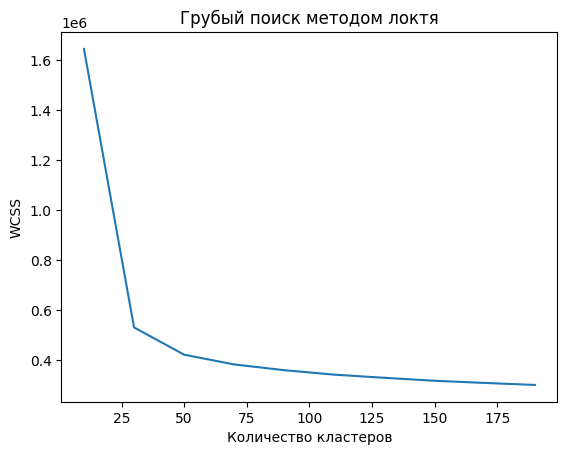

In [ ]:
method_loktja(sample_normalize, range(10,201, 20))

По результату грубого поиска видно, что явно выраженный "локоть" находится в районе 30го кластера, но дополнительные "локти" можно исследовать между 20 и 60-ым кластерами. В этом диапазоне проведем более точный поиск.

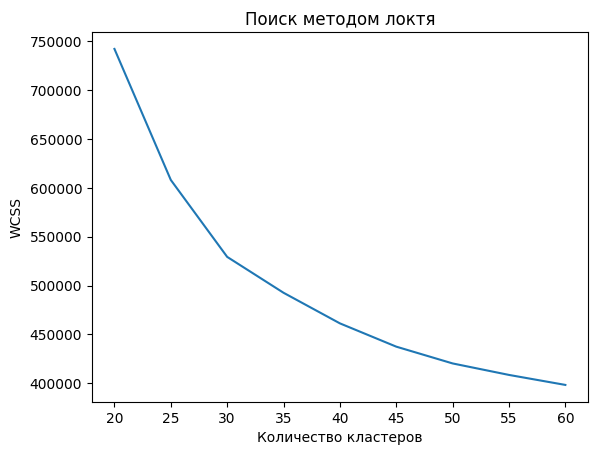

In [ ]:
method_loktja(sample_normalize, range(20, 65, 5))

Однако, детальный анализ не позволил определить явное количество кластеров, из-за отсутствия выраженного места перелома линии WCSS. Расстояние до центроидов кластеров от элементов, попавших в кластер, уменьшается достаточно плавно, что свидетельствует о том, что либо данные не имеют явно выраженной кластерной структуры, либо "локоть" настолько плавный, что его трудно определить без дополнительных методов.
Применем метод силуэтого анализа в качестве дополнительного анализа.

### Силуэтный анализ

In [ ]:
def silhouette_analize(data, range_n_clusters, step):
  silhouette_avg_scores = []
  for n_clusters in range_n_clusters:
      clusterer = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10, max_iter=300, random_state=0)
      cluster_labels = clusterer.fit_predict(data)
      silhouette_avg = silhouette_score(data, cluster_labels)
      silhouette_avg_scores.append(silhouette_avg)
      print(f"Для количества кластеров = {n_clusters}, усредненный силуэтный коэффициент : {silhouette_avg}")
  plt.figure(figsize=(6, 4))
  bar_width = step - 0.2
  bar_color = '#4daf4a'
  plt.bar(range_n_clusters, silhouette_avg_scores, width=bar_width, color=bar_color)
  plt.xticks(range_n_clusters)
  plt.xlabel("Количество кластеров")
  plt.ylabel("Среднее силуэтного коэффициента")
  plt.title("Силуэтный анализ для определения оптимального количества кластеров")
  plt.show()

Для количества кластеров = 10, усредненный силуэтный коэффициент : 0.8438455531855696
Для количества кластеров = 15, усредненный силуэтный коэффициент : 0.7834086611998543
Для количества кластеров = 20, усредненный силуэтный коэффициент : 0.13586825854723156
Для количества кластеров = 25, усредненный силуэтный коэффициент : 0.13485694414104912
Для количества кластеров = 30, усредненный силуэтный коэффициент : 0.1074973028425906
Для количества кластеров = 35, усредненный силуэтный коэффициент : 0.1002217514148807
Для количества кластеров = 40, усредненный силуэтный коэффициент : 0.09959377295792715
Для количества кластеров = 45, усредненный силуэтный коэффициент : 0.09130153258927384
Для количества кластеров = 50, усредненный силуэтный коэффициент : 0.09230430981559481
Для количества кластеров = 55, усредненный силуэтный коэффициент : 0.08379057644453257


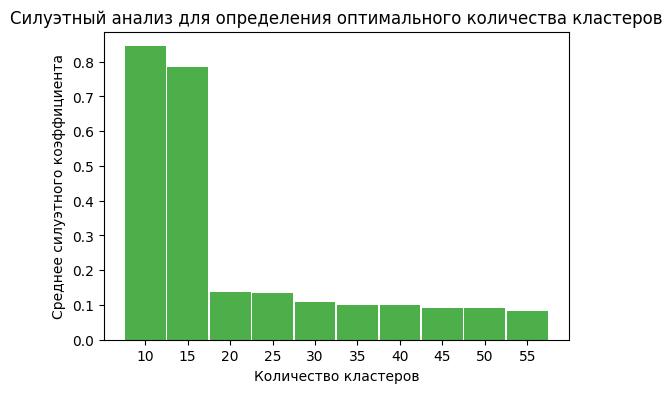

In [ ]:
range_n_clusters = range(10, 60, 5)
silhouette_analize(sample_normalize, range_n_clusters=range_n_clusters, step=5)

Для количества кластеров = 2, усредненный силуэтный коэффициент : 0.8985990060451866
Для количества кластеров = 3, усредненный силуэтный коэффициент : 0.8877242825810198
Для количества кластеров = 4, усредненный силуэтный коэффициент : 0.8773684707152856
Для количества кластеров = 5, усредненный силуэтный коэффициент : 0.8738524354484783
Для количества кластеров = 6, усредненный силуэтный коэффициент : 0.8589783165548046
Для количества кластеров = 7, усредненный силуэтный коэффициент : 0.8558160667424473
Для количества кластеров = 8, усредненный силуэтный коэффициент : 0.8465007727006323
Для количества кластеров = 9, усредненный силуэтный коэффициент : 0.8476307440311249
Для количества кластеров = 10, усредненный силуэтный коэффициент : 0.8438455531855696
Для количества кластеров = 11, усредненный силуэтный коэффициент : 0.7966867482153283
Для количества кластеров = 12, усредненный силуэтный коэффициент : 0.7945578851069751
Для количества кластеров = 13, усредненный силуэтный коэффицие

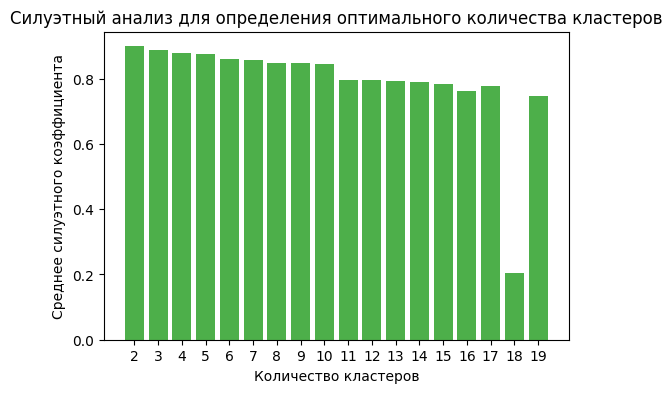

In [ ]:
range_n_clusters = range(2, 20, 1)
silhouette_analize(sample_normalize, range_n_clusters=range_n_clusters, step=1)

Силуэтный коэффициент указывает на то, что 10 кластеров по объяснимости (сепорации и несмешиваемости) намного лучше себя показывает, чем большее количество кластеров.

## 3. Бейзлайн: стандартизация - кластеризания - поиск соседей

In [18]:
base_scale = scaler.transform(base)

In [21]:
kmeans = KMeans(n_clusters=10, init="k-means++", max_iter=300, random_state=0)
kmeans.fit(base_scale)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=0)

In [21]:
X = train.drop("Target", axis=1)
X_normalize = scaler.transform(X)

In [30]:
def acc_top_5(data_normalize, data_original, base_data):

  train_claster_predict = kmeans.predict(data_normalize)
  # Создание словаря для отображения числовых индексов на текстовые
  index_mapping = {i: idx for i, idx in enumerate(base.index)}

  # Создание словаря для хранения индексов NumPy для каждого кластера
  cluster_indices = {cluster: np.where(kmeans.labels_ == cluster)[0] for cluster in np.unique(kmeans.labels_)}

  accuracy = 0
  for cluster in tqdm(np.unique(train_claster_predict), desc="Processing clusters"):
      base_cluster_indices = cluster_indices[cluster]
      base_cluster = base_data[base_cluster_indices]
      train_cluster = data_normalize[train_claster_predict == cluster]
      true_labels_cluster = data_original[train_claster_predict == cluster]['Target']

      neighbors = NearestNeighbors(n_neighbors=5)
      neighbors.fit(base_cluster)

      _, indices = neighbors.kneighbors(train_cluster)

      for target, idx in zip(true_labels_cluster.values.tolist(), indices):
          # Преобразование числовых индексов в текстовые для сопоставления
          text_indices = [index_mapping[base_cluster_indices[i]] for i in idx]
          accuracy += int(target in text_indices)

  total_accuracy = 100 * accuracy / len(train)
  print(f"Total Accuracy: {total_accuracy:.2f}%")


In [28]:
acc_top_5(X_normalize, train, base_scale)

Processing clusters: 100%|██████████| 10/10 [26:50<00:00, 161.07s/it]

Total Accuracy: 53.83%


## 4. Бейзлайн + PCA

Решение задачи классическим методом K_means + KNN демонстрирует свою состоятельность, хотя accuracy@5 не является достаточно большим. Применение PCA (метод главных компонент), может значительно ускорить процесс решения задачи, за счет снижения размерности данных, что позволит проводить тесты по подбору оптимальных параметров более широко.  
PCA является также обучаемым алгоритмом, и требует задания количества компонент, которые способны объяснить некоторою дисперсию данных. Обычно порог для доли объяснимой дисперсии выставляют равной 95%. Однако, более высокие показатели данного параметра могут привести к лучшим результатам.

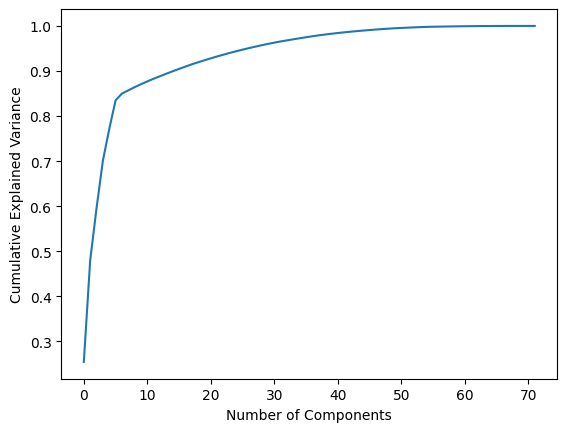

[0.25463985 0.47958686 0.59558447 0.70084574 0.77106967 0.83485052
 0.84995355 0.8570892  0.86410819 0.87075278 0.87692968 0.88284712
 0.88850496 0.89406683 0.89941751 0.90465916 0.90979759 0.91479407
 0.91938546 0.92378539 0.92814157 0.93233464 0.93628531 0.94020905
 0.94391643 0.94743002 0.95078285 0.95402219 0.95716488 0.96015994
 0.96293799 0.965533   0.96801469 0.97033918 0.97263249 0.97491884
 0.97709868 0.9791     0.98092129 0.98266604 0.98427848 0.98578277
 0.98719243 0.98849863 0.98970513 0.99088899 0.99198812 0.99303097
 0.99394556 0.99484952 0.99553426 0.99618018 0.99678508 0.99734421
 0.99788161 0.99819852 0.99845838 0.99870331 0.99894469 0.99916054
 0.99931396 0.99946445 0.99959795 0.99969476 0.99978258 0.99984308
 0.99989376 0.99992836 0.99996217 0.99999423 0.99999916 1.        ] 27


In [ ]:
# Применение PCA без уменьшения размерности для анализа
pca = PCA()
pca.fit(sample)

# Кумулятивная объясненная дисперсия
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# График каменистой осыпи
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Определение оптимального количества компонент
optimal_components = sum(cumulative_variance < 0.95) + 1
print(cumulative_variance, optimal_components)

Доля объясненной дисперсии в 95% достигается при 27 главных компонент. Таким образом, количество компанент можно установить в 27 и более.

In [31]:
pca = PCA(n_components=27)
base_scale_pca = pca.fit_transform(base_scale)

In [32]:
X_normalize_pca = pca.transform(X_normalize)

In [33]:
kmeans = KMeans(n_clusters=10, init="k-means++", n_init=10, max_iter=300, random_state=0)
kmeans.fit(base_scale_pca)

KMeans(n_clusters=10, n_init=10, random_state=0)

In [34]:
acc_top_5(X_normalize_pca, train, base_scale_pca)

Processing clusters: 100%|██████████| 10/10 [18:43<00:00, 112.34s/it]

Total Accuracy: 47.66%


Accuracy@5 ожидаемо упало с применением PCA, но падание оказалось достаточно значимым - практически 5 %. Время в свою очередь уменьшилось с 26 минут до 18ти на обработку одного и тогоже набора данных.

## 5. FAISS

Faiss - это инструмент, разработанный Facebook для быстрого поиска ближайших соседей в больших наборах данных. Он особенно полезен, когда обычные методы поиска, такие как KMeans и KNN, работают медленно из-за большого количества данных.

Когда дело доходит до обработки больших данных, Faiss может значительно ускорить поиск, предлагая специальные техники и настройки. Это важно для задач, где нужно быстро находить совпадения или "мэтчи" среди большого количества данных.  

Использование Faiss включает:
- подготовку данных,  
- создание специального "индекса" для поиска,  
- поиск ближайших соседей.

Мы можем настроить Faiss для баланса между быстротой и точностью поиска, что делает его хорошим выбором для задач с большими данными.

In [40]:
sample_ = train.sample(n=10_000, random_state=0)
sample_x = sample_.drop("Target", axis=1)
sample_x_normalize = scaler.transform(sample_x)

base_data = base_scale.astype(np.float32)
train_data = sample_x_normalize.astype(np.float32)
train_labels = sample_['Target']

In [41]:
def create_and_train_index(data, 
                           n_clusters=None, 
                           use_pca=False, 
                           pca_dimensions=None, 
                           metric=faiss.METRIC_L2):
    d = data.shape[1]
    
    # Применение PCA, если требуется
    if use_pca and pca_dimensions:
        pca_matrix = faiss.PCAMatrix(d, pca_dimensions, eigen_power=-0.5)
        pca_matrix.train(data)
        data = pca_matrix.apply_py(data)
        d = pca_dimensions  # Новая размерность после PCA

    # Создание индекса
    if n_clusters:
        quantizer = faiss.IndexFlatL2(d)
        index = faiss.IndexIVFFlat(quantizer, d, n_clusters, metric)
        index.train(data)
    else:
        index = faiss.IndexFlatL2(d)

    index.add(data)
    return index, (pca_matrix if use_pca and pca_dimensions else None)

In [42]:
def search_neighbors(index, query_data, k=5, pca_matrix=None):
    start_time = time.time()
    if pca_matrix:
        query_data = pca_matrix.apply_py(query_data)
    distances, indices = index.search(query_data, k)
    print(f"Поиск занял {time.time() - start_time:.2f} секунд")
    return distances, indices

In [43]:
def calculate_accuracy(indices, train_labels, index_to_label):
    correct_matches = sum(label in [index_to_label[idx] for idx in neighbors] for label, neighbors in zip(train_labels, indices))
    accuracy = 100 * correct_matches / len(train_labels)
    return accuracy

Для выбора субоптимальных (оптимальных при заданных условиях) гиперпараметров FAISS воспользуемся библиотекой Optuna. Это инструмент, подходящий для настройки гиперпараметров Faiss, который помогает нам найти лучший баланс между скоростью и точностью при поиске данных. С Optuna мы можем автоматически проверять разные варианты настроек Faiss, чтобы увидеть, какие из них работают лучше всего для нашей задачи. Это упрощает процесс и помогает нам добиться хороших результатов быстрее, особенно когда у нас много данных для обработки.

In [45]:
def perform_matching(base_data, train_data, train_labels, 
                     n_clusters=None, 
                     use_pca=False, 
                     pca_dimensions=None, 
                     k=5, nprobe=2, 
                     metric=faiss.METRIC_L2):
    
    # Создание и обучение индекса
    index, pca_matrix = create_and_train_index(base_data, 
                                               n_clusters=n_clusters, 
                                               use_pca=use_pca, 
                                               pca_dimensions=pca_dimensions,
                                               metric=metric)

    # Установка параметра nprobe для индекса
    index.nprobe = nprobe

    # Поиск ближайших соседей
    _, indices = search_neighbors(index, train_data, k=k, pca_matrix=pca_matrix)

    # Создание словаря для сопоставления индексов и меток
    index_to_label = {idx: label for idx, label in enumerate(base.index)}

    # Расчет точности сопоставления
    accuracy = calculate_accuracy(indices, train_labels, index_to_label)
    return accuracy


In [47]:
def objective(trial):
    # Определение пространства поиска гиперпараметров
    n_clusters = trial.suggest_int('n_clusters', 10, 500, step=10)

    pca_dimensions_option = trial.suggest_categorical('pca_dimensions_option', [True, False])
    pca_dimensions = trial.suggest_int('pca_dimensions', 27, 70) if pca_dimensions_option else None

    nprobe = trial.suggest_int('nprobe', 1, 10)

    accuracy = perform_matching(base_data, train_data, train_labels, 
                                n_clusters=n_clusters, 
                                use_pca=pca_dimensions_option, 
                                pca_dimensions=pca_dimensions, 
                                k=5, nprobe=nprobe)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Вы можете настроить количество испытаний

print("Лучшая точность:", study.best_value)
print("Лучшие параметры:", study.best_params)

[I 2024-01-30 05:03:38,754] A new study created in memory with name: no-name-044b458a-2363-4679-a1d5-6c1d3e758f0c


Поиск занял 9.07 секунд


[I 2024-01-30 05:04:04,409] Trial 0 finished with value: 52.68 and parameters: {'n_clusters': 430, 'pca_dimensions_option': False, 'nprobe': 7}. Best is trial 0 with value: 52.68.


Поиск занял 9.03 секунд


[I 2024-01-30 05:04:25,568] Trial 1 finished with value: 52.2 and parameters: {'n_clusters': 250, 'pca_dimensions_option': False, 'nprobe': 5}. Best is trial 0 with value: 52.68.


Поиск занял 17.11 секунд


[I 2024-01-30 05:04:49,568] Trial 2 finished with value: 52.17 and parameters: {'n_clusters': 80, 'pca_dimensions_option': False, 'nprobe': 4}. Best is trial 0 with value: 52.68.


Поиск занял 5.59 секунд


[I 2024-01-30 05:05:02,395] Trial 3 finished with value: 51.14 and parameters: {'n_clusters': 180, 'pca_dimensions_option': False, 'nprobe': 3}. Best is trial 0 with value: 52.68.


Поиск занял 20.80 секунд


[I 2024-01-30 05:05:30,457] Trial 4 finished with value: 53.14 and parameters: {'n_clusters': 150, 'pca_dimensions_option': False, 'nprobe': 8}. Best is trial 4 with value: 53.14.


Поиск занял 5.54 секунд


[I 2024-01-30 05:05:40,472] Trial 5 finished with value: 46.58 and parameters: {'n_clusters': 40, 'pca_dimensions_option': True, 'pca_dimensions': 28, 'nprobe': 1}. Best is trial 4 with value: 53.14.


Поиск занял 25.83 секунд


[I 2024-01-30 05:06:13,143] Trial 6 finished with value: 53.18 and parameters: {'n_clusters': 130, 'pca_dimensions_option': False, 'nprobe': 8}. Best is trial 6 with value: 53.18.


Поиск занял 2.42 секунд


[I 2024-01-30 05:06:22,195] Trial 7 finished with value: 46.75 and parameters: {'n_clusters': 160, 'pca_dimensions_option': False, 'nprobe': 1}. Best is trial 6 with value: 53.18.


Поиск занял 12.24 секунд


[I 2024-01-30 05:06:44,616] Trial 8 finished with value: 53.0 and parameters: {'n_clusters': 300, 'pca_dimensions_option': False, 'nprobe': 10}. Best is trial 6 with value: 53.18.


Поиск занял 7.64 секунд


[I 2024-01-30 05:07:05,568] Trial 9 finished with value: 52.81 and parameters: {'n_clusters': 500, 'pca_dimensions_option': False, 'nprobe': 10}. Best is trial 6 with value: 53.18.


Поиск занял 8.72 секунд


[I 2024-01-30 05:07:24,889] Trial 10 finished with value: 66.19 and parameters: {'n_clusters': 320, 'pca_dimensions_option': True, 'pca_dimensions': 68, 'nprobe': 7}. Best is trial 10 with value: 66.19.


Поиск занял 9.25 секунд


[I 2024-01-30 05:07:46,269] Trial 11 finished with value: 63.76 and parameters: {'n_clusters': 330, 'pca_dimensions_option': True, 'pca_dimensions': 70, 'nprobe': 7}. Best is trial 10 with value: 66.19.


Поиск занял 7.03 секунд


[I 2024-01-30 05:08:05,182] Trial 12 finished with value: 63.34 and parameters: {'n_clusters': 350, 'pca_dimensions_option': True, 'pca_dimensions': 70, 'nprobe': 6}. Best is trial 10 with value: 66.19.


Поиск занял 7.56 секунд


[I 2024-01-30 05:08:24,156] Trial 13 finished with value: 64.81 and parameters: {'n_clusters': 380, 'pca_dimensions_option': True, 'pca_dimensions': 69, 'nprobe': 8}. Best is trial 10 with value: 66.19.


Поиск занял 6.04 секунд


[I 2024-01-30 05:08:40,582] Trial 14 finished with value: 65.87 and parameters: {'n_clusters': 420, 'pca_dimensions_option': True, 'pca_dimensions': 58, 'nprobe': 9}. Best is trial 10 with value: 66.19.


Поиск занял 5.50 секунд


[I 2024-01-30 05:08:55,789] Trial 15 finished with value: 64.91 and parameters: {'n_clusters': 430, 'pca_dimensions_option': True, 'pca_dimensions': 52, 'nprobe': 9}. Best is trial 10 with value: 66.19.


Поиск занял 7.27 секунд


[I 2024-01-30 05:09:10,582] Trial 16 finished with value: 64.62 and parameters: {'n_clusters': 260, 'pca_dimensions_option': True, 'pca_dimensions': 55, 'nprobe': 6}. Best is trial 10 with value: 66.19.


Поиск занял 6.19 секунд


[I 2024-01-30 05:09:28,033] Trial 17 finished with value: 66.22 and parameters: {'n_clusters': 470, 'pca_dimensions_option': True, 'pca_dimensions': 59, 'nprobe': 9}. Best is trial 17 with value: 66.22.


Поиск занял 3.57 секунд


[I 2024-01-30 05:09:43,256] Trial 18 finished with value: 65.17 and parameters: {'n_clusters': 490, 'pca_dimensions_option': True, 'pca_dimensions': 61, 'nprobe': 5}. Best is trial 17 with value: 66.22.


Поиск занял 6.98 секунд


[I 2024-01-30 05:09:56,923] Trial 19 finished with value: 61.35 and parameters: {'n_clusters': 230, 'pca_dimensions_option': True, 'pca_dimensions': 42, 'nprobe': 7}. Best is trial 17 with value: 66.22.


Поиск занял 5.89 секунд


[I 2024-01-30 05:10:11,927] Trial 20 finished with value: 62.59 and parameters: {'n_clusters': 390, 'pca_dimensions_option': True, 'pca_dimensions': 44, 'nprobe': 9}. Best is trial 17 with value: 66.22.


Поиск занял 6.47 секунд


[I 2024-01-30 05:10:29,374] Trial 21 finished with value: 66.16 and parameters: {'n_clusters': 440, 'pca_dimensions_option': True, 'pca_dimensions': 60, 'nprobe': 9}. Best is trial 17 with value: 66.22.


Поиск занял 7.09 секунд


[I 2024-01-30 05:10:47,999] Trial 22 finished with value: 66.78 and parameters: {'n_clusters': 460, 'pca_dimensions_option': True, 'pca_dimensions': 62, 'nprobe': 10}. Best is trial 22 with value: 66.78.


Поиск занял 6.78 секунд


[I 2024-01-30 05:11:06,622] Trial 23 finished with value: 66.76 and parameters: {'n_clusters': 470, 'pca_dimensions_option': True, 'pca_dimensions': 63, 'nprobe': 10}. Best is trial 22 with value: 66.78.


Поиск занял 7.11 секунд


[I 2024-01-30 05:11:25,453] Trial 24 finished with value: 66.65 and parameters: {'n_clusters': 480, 'pca_dimensions_option': True, 'pca_dimensions': 63, 'nprobe': 10}. Best is trial 22 with value: 66.78.


Лучшая точность: 66.78
Лучшие параметры: {'n_clusters': 460, 'pca_dimensions_option': True, 'pca_dimensions': 62, 'nprobe': 10}


Результат оптимизации с использованием Optuna показывает, что лучшая достигнутая точность в задаче мэтчинга составляет 66.78%. Это означает, что в 66.78% случаев алгоритм смог правильно идентифицировать ближайших соседей или совпадения в данных среди топ5 сопоставлений.

Лучшие настроенные параметры для Faiss, которые привели к этому результату, следующие:

- n_clusters = 460. Это количество кластеров, используемых в индексе Faiss. Большее количество кластеров потенциально помогло повысить точность, предоставляя более детализированное разделение данных, а также позволило повысить скорость поиска ближайших соседей.
- pca_dimensions_option = True. Это указывает на использование метода главных компонент (PCA) для уменьшения размерности данных перед кластеризацией.
- pca_dimensions = 62. Количество измерений после применения PCA. Уменьшение размерности до 62 помогло улучшить точность, сохраняя при этом достаточно информации о данных. Использование 62 компонент позволяет повысить долю объяснимой дисперсии более 99%.
- nprobe = 10. Это параметр, который определяет, сколько кластеров будет исследовано при поиске ближайших соседей. Установка его в значение 10 обеспечила хороший баланс между скоростью и точностью поиска.  

Эти параметры представляют оптимальную конфигурацию для задачи мэтчинга, согласно результатам оптимизации Optuna.

Проведем дополнительное исследование, чтобы подтвердить, что уменьшение количества кластеров ведет к увеличению точности сопоставления, но также увеличению времени обработки.

In [50]:
accuracy = perform_matching(base_data, train_data, train_labels, n_clusters=10, use_pca=True, pca_dimensions=65, k=5, nprobe=10)
print(f"Точность метчинга: {accuracy:.2f}%")

Поиск занял 297.64 секунд
Точность метчинга: 69.00%


In [51]:
accuracy = perform_matching(base_data, train_data, train_labels, n_clusters=60, use_pca=True, pca_dimensions=65, k=5, nprobe=10)
print(f"Точность метчинга: {accuracy:.2f}%")

Поиск занял 69.81 секунд
Точность метчинга: 67.75%


---
По данным результатам видно, что точность вырастает при уменьшении количества кластеров (~ на 2.2% при уменьшении количества кластеров с 460 до 10-ти и на 1% с 460 до 60-ти). Однако время обработки увеличивается в 42 раза и 9.5 раз соответсвтенно.  

При поиске разумного сочетания скорости и точности, полученные параметры при оптимизации кажутся наиболее подходящие.

## 6. Финальное тестирование на валидационном наборе данных

In [53]:
validation_normalize = scaler.transform(validation)
val_data = validation_normalize.astype(np.float32)

In [54]:
val_answer = validation_answer["Expected"]

In [55]:
accuracy = perform_matching(base_data, val_data, val_answer, n_clusters=480, use_pca=True, pca_dimensions=65, k=5, nprobe=10)
print(f"Точность метчинга: {accuracy:.2f}%")

Поиск занял 67.04 секунд
Точность метчинга: 67.02%


На валидационном наборе данных точность достигла 67 %, что соответствует семплированной выборке из набора train, составляющего 10 % от размеров валидационной выборки.

## Заключение

---
В рамках проекта была поставлена задача определения пяти наиболее схожих товаров из большого набора данных, содержащего более 3 миллионов записей с 72 признаками каждая. Для эффективного решения этой задачи были применены методы машинного обучения, оптимизации и кластеризации.

В процессе работы были выполнены следующие ключевые шаги:

1. Проведен исследовательский анализ данных, включая проверку пропущенных значений, дубликатов, анализ распределения признаков и корреляции между ними.
2. Для борьбы с выбросами и различным масштабом признаков применена стандартизация данных с использованием `RobustScaler`.
3. Использован метод кластеризации K-means для снижения размерности и упрощения поиска ближайших соседей. Применен метод "локтя" и силуэтный анализ для определения оптимального числа кластеров.
4. Для ускорения поиска ближайших соседей использован инструмент Faiss, разработанный Facebook AI Research.
5. Применена библиотека Optuna для оптимизации гиперпараметров Faiss, что позволило найти наиболее эффективное сочетание параметров для баланса между скоростью и точностью поиска.

В результате оптимизации была достигнута точность мэтчинга 66.78%, что является хорошим результатом учитывая объем и сложность данных. Полученные параметры Faiss (460 кластеров, использование PCA с 62 компонентами, `nprobe` равным 10) показали себя эффективными в достижении баланса между скоростью и тоПаключение, проект демонстрирует успешное применение комбинации различных методов машинного обучения и оптимизации для решения сложной задачи поиска схожих товаров в большом и многомерном пространстворов данных.